<a href="https://colab.research.google.com/github/himanshuktgkb/Computer-vision/blob/main/Feature_Extraction_Using_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


In [3]:
from google.colab.patches import cv2_imshow

In [15]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [16]:
img1 = cv.imread('/content/2023-02-21.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('/content/image3.jpg',cv.IMREAD_GRAYSCALE)

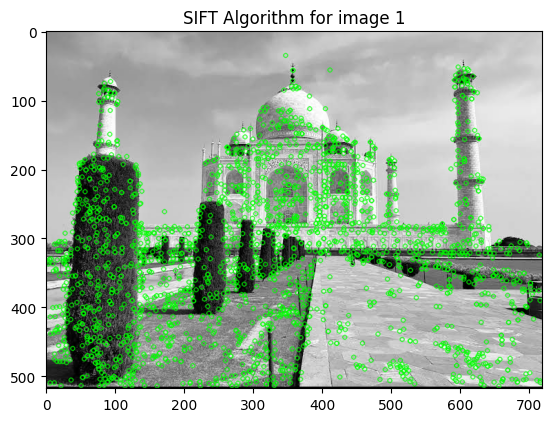

In [17]:
#  Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints with SIFT
kp = sift.detect(img1,None)
# compute the descriptors with SIFT
kp, des = sift.compute(img1, kp)
# draw only keypoints location,not size and orientation
imgResult = cv.drawKeypoints(img1, kp, None, color=(0,255,0), flags=0)
plt.title('SIFT Algorithm for image 1')
plt.imshow(imgResult)
plt.show()

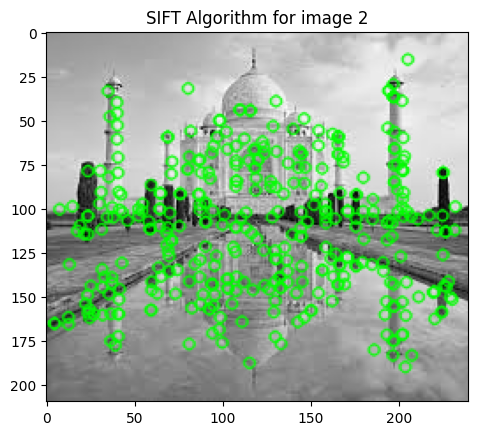

In [18]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints with SIFT
kp = sift.detect(img2,None)
# compute the descriptors with SIFT
kp, des = sift.compute(img2, kp)
# draw only keypoints location,not size and orientation
imgResult = cv.drawKeypoints(img2, kp, None, color=(0,255,0), flags=0)
plt.title('SIFT Algorithm for image 2')
plt.imshow(imgResult)
plt.show()

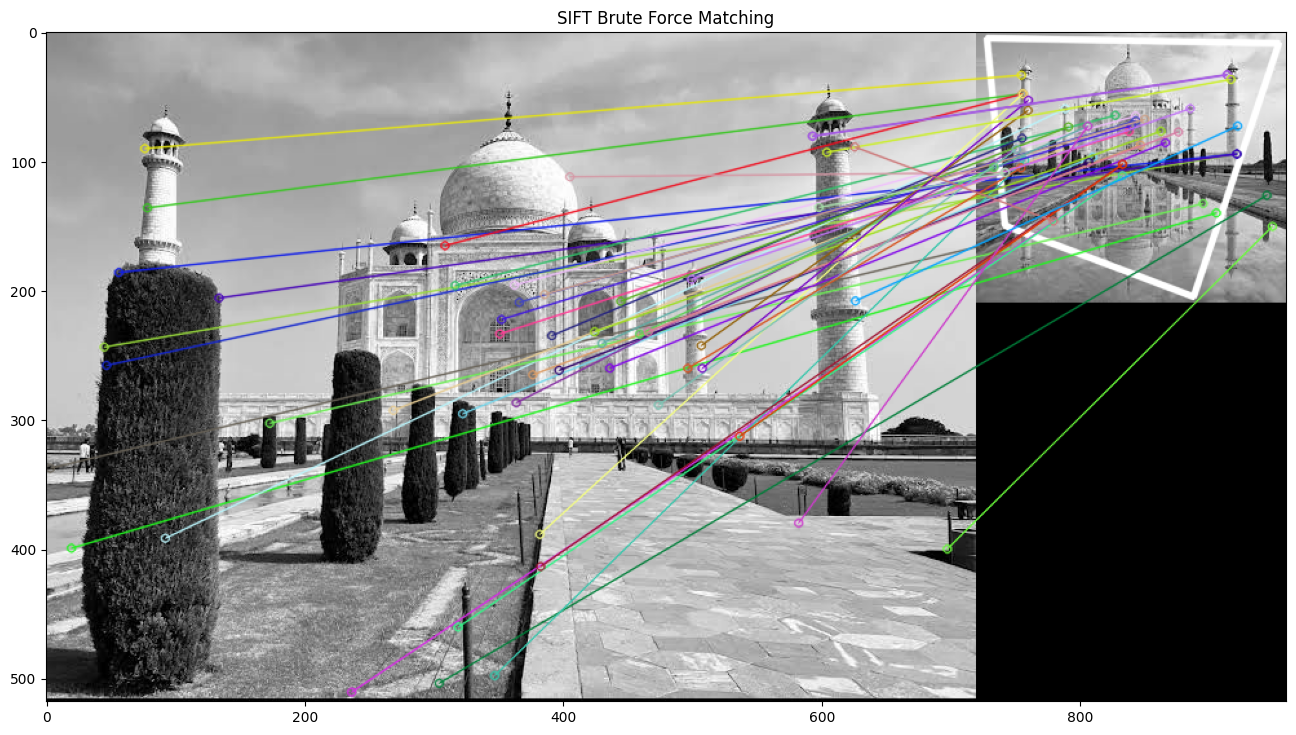

In [27]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default parameters
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 16))
plt.title('SIFT Brute Force Matching')
plt.imshow(img3)
plt.show()

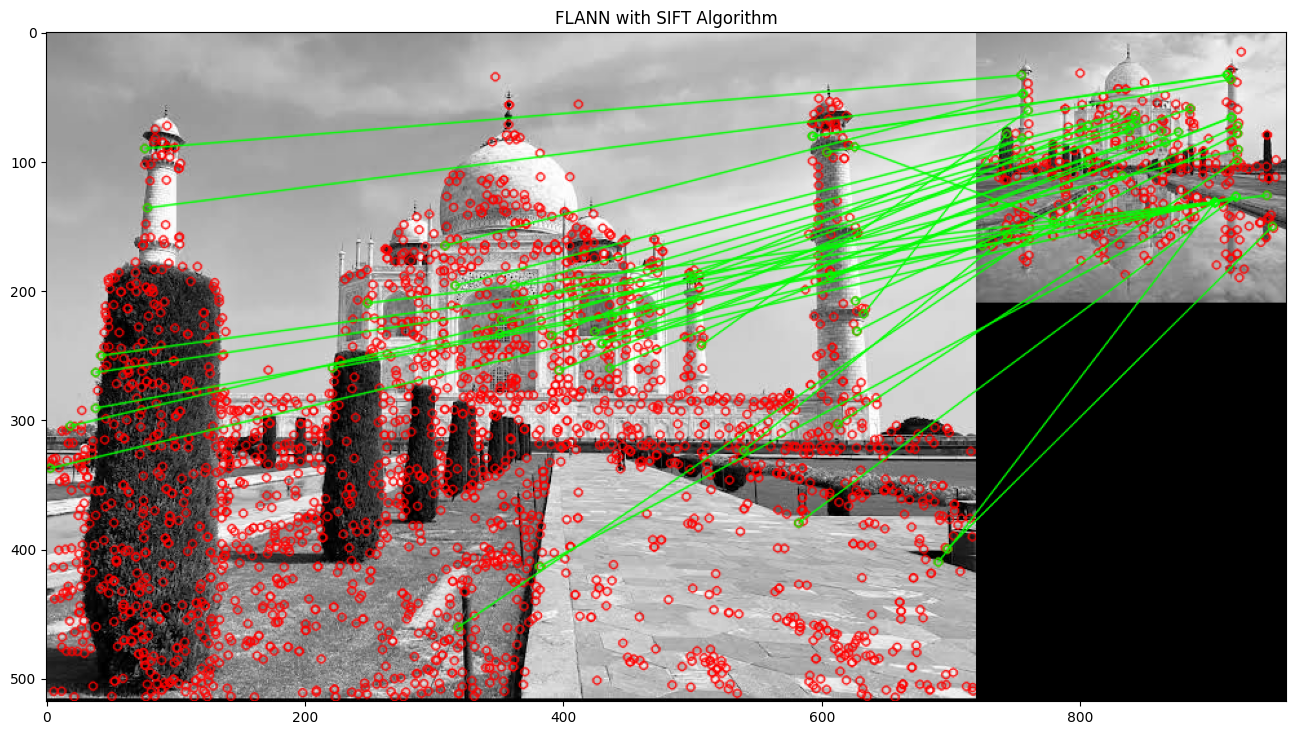

(<matplotlib.image.AxesImage at 0x7b97e0520eb0>, None)

In [20]:
# SIFT Algorithm
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(16, 16))
plt.title('FLANN with SIFT Algorithm')
plt.imshow(img3,'gray'),plt.show()

In [21]:
MIN_MATCH_COUNT = 10
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


In [22]:
img1.shape


(518, 720)

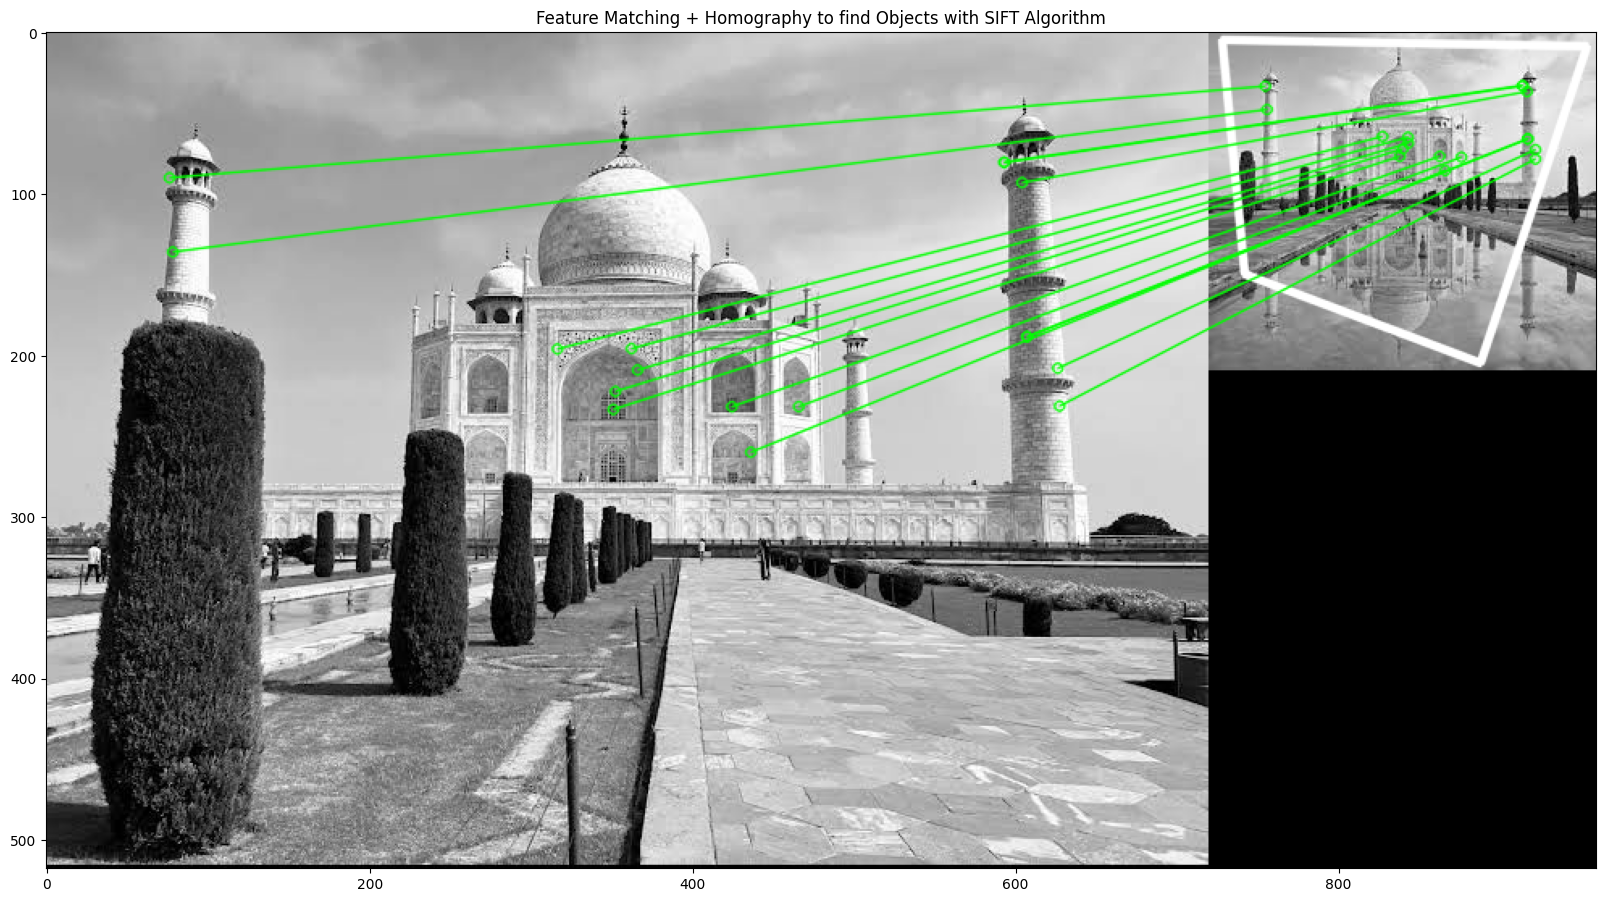

Time:  1.1427693529999488


In [23]:
import timeit

start = timeit.default_timer()

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[h-1,w-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(20, 20))
plt.title('Feature Matching + Homography to find Objects with SIFT Algorithm')
plt.imshow(img3, 'gray'),plt.show()

stop = timeit.default_timer()
waktu = stop - start
print('Time: ', stop - start)